The research was supported by the Ministry of Innovation and Technology NRDI Office within the framework of the MILAB Artificial Intelligence National Laboratory Program.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import torch
import torch.nn as nn

NSAMPLE = 10
MAX_PIX_NUM = 100
XMAX = 1024.
YMAX = 512.

def read_datafile(datafile="head_input_230MeV_cs.txt"):
    l = []
    i = 0

    with open(datafile, "r") as f:
        while True:
            line = f.readline()
            if len(line) == 0:
                break; # eof
            while len(line.strip()) == 0:
                line = f.readline() # skip blank lines
            lf = line.split()
            gtruth = np.array([float(lf[2])/XMAX,float(lf[3])/YMAX,lf[5]],dtype=float)
            inp = np.vstack(([float(x)/XMAX for x in lf[7::2]],[float(y)/YMAX for y in lf[8::2]])).ravel(order='F')
#            inp = np.array(lf[7:],dtype=int)
            if len(inp)>0:
                l.append([gtruth,inp])
                i += 1
    return l

print("Reading data file ...")
l = read_datafile()
print("Done...")

def trainLoader(batch_size):
    x = [None] * batch_size
    y = [None] * batch_size
    for ib in range(batch_size):
        sel = [randint(0,len(l)-1) for p in range(NSAMPLE)]
        
        try:
            t0 = np.concatenate([l[i][1] for i in sel])
        except IndexError:
            print('sel = ',sel)
            return()
        while(len(t0) > 2*MAX_PIX_NUM):
            sel = [randint(0,len(l)-1) for p in range(NSAMPLE)]
            t0 = np.concatenate([l[i][1] for i in sel])
        t = np.unique(XMAX*t0[0::2]+t0[1::2])
        ind = np.argsort(t)
        x[ib] = np.zeros(2*MAX_PIX_NUM,dtype=float)
#        x[ib] = 1e-10*np.ones(2*MAX_PIX_NUM,dtype=float)
        x[ib][:2*len(t)] = np.concatenate([[int(t[i])/XMAX, t[i]-int(t[i])] for i in ind])

        t1 = [XMAX*l[i][0][0]+l[i][0][1] for i in sel]
        ind = np.argsort(t1)
        y[ib] = np.concatenate([l[sel[i]][0] for i in ind])
        
    return torch.FloatTensor(x), torch.FloatTensor(y)


Reading data file ...
Done...


In [2]:
# For installing CUDA support see https://pytorch.org/

#import torch
#import torch.nn as nn
#import numpy as np

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")
#DEVICE = torch.device("cpu")
print("DEVICE is {}".format(DEVICE))
CPU_DEV = torch.device("cpu")


batch_size = 64

x_dim  = 2*100
hidden_dim = 32
#latent_dim = 10 # twice: mean / log_var
latent_dim = 20 # twice: mean / log_var
output_dim = 3*10 # (X,Y,Edep) for 10 hits

lr = 1e-3

epochs = 20

DEVICE is cuda


In [3]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        self.training = True
        
    def forward(self, x):
        h_       = torch.relu(self.FC_input(x))
        mean     = self.FC_mean(h_)
#        print('mean:',mean)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
#        print('log_var:',log_var)
                                                       #             (i.e., parateters of simple tractable normal distribution "q")
        var      = torch.exp(0.5*log_var)              # takes exponential function
#        print('var:',var)
        z        = self.reparameterization(mean, var)
        
        return z, mean, log_var
       
    def reparameterization(self, mean, var,):
        epsilon = torch.rand_like(var).to(DEVICE)        # sampling epsilon
        
        z = mean + var*epsilon                          # reparameterization trick
        
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h     = torch.relu(self.FC_hidden(x))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
    
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
                
    def forward(self, x):
        z, mean, log_var = self.Encoder(x)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

class Model2(nn.Module):
    def __init__(self, Encoder, Encoder2, Decoder):
        super(Model2, self).__init__()
        self.Encoder = Encoder
        self.Encoder2 = Encoder2
        self.Decoder = Decoder
                
    def forward(self, x):
        z2, mean2, log_var2 = self.Encoder2(x[:,x_dim:(x_dim+output_dim)])
        z, mean, log_var = self.Encoder(x[:,0:x_dim])
        x_hat            = self.Decoder(z2)
        
        return x_hat, mean, log_var, mean2, log_var2

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
encoder2 = Encoder(input_dim=output_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = output_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)
model2= Model2(Encoder=encoder, Encoder2=encoder2, Decoder=decoder).to(DEVICE)
model3= Model(Encoder=encoder2, Decoder=decoder).to(DEVICE)

from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(y, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, y, reduction='sum')
#    reproduction_loss = nn.MSELoss()
    KLD = 0.
#    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

#    return reproduction_loss(x_hat, y) + KLD    
    return reproduction_loss + KLD

EPS = 1e-10
def loss_function2(y,x_hat, mean, log_var, mean2, log_var2):
    reproduction_loss = torch.sum(y-x_hat+x_hat*torch.log((x_hat+EPS)/(y+EPS)))  # something to regularize y=0 ...
    var = torch.exp(0.5*log_var)
    var2 = torch.exp(0.5*log_var2)
    dv = var/var2
    KLD = torch.sum((mean-mean2)**2*0.5/var**2 + torch.log(dv) + 0.5/dv**2-0.5)

#    print('rep_error: {0}, KLD: {1}'.format(reproduction_loss,KLD))
#    return reproduction_loss + KLD
    return reproduction_loss + 100.*KLD


def MSEloss(y,x_hat):
    return torch.sum((y-x_hat)**2)
    
optimizer = Adam(model.parameters(), lr=lr)

## Encoder1 + Encoder 2 -> Decoder model

Update is done in two steps for each epoch:
- first, only the Encoder2 - > Decoder part is updated based on the MSELoss(inp,out)
- next, encoder2 and decoder are fixed and only Encoder(1) is updated based on the distances of the Gaussian parameters (mean and var of Encoder1 and Encoder2)

In [76]:
# Encoder1 + Encoder2 -> Decoder model
import time

epochs = 40

encoder2 = Encoder(input_dim=output_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = output_dim)
model2= Model2(Encoder=encoder, Encoder2=encoder2, Decoder=decoder).to(DEVICE)
optimizer = Adam(model2.parameters(), lr=lr)

One_params = [{'params': model2.Encoder.parameters()}]
optimizerOne = Adam(One_params, lr=lr)
Two_params = [{'params': model2.Encoder2.parameters()}, {'params': model2.Decoder.parameters()}]
optimizerTwo = Adam(Two_params, lr=lr)


EPS = 1e-10
def loss_function2(Xy,x_hat, mean, log_var, mean2, log_var2, mode):
#    reproduction_loss = torch.sum(y-x_hat+x_hat*torch.log((x_hat+EPS)/(y+EPS)))  # something to regularize y=0 ...
    if(mode == 2):
        reproduction_loss = torch.sum((Xy[:,x_dim:(x_dim+output_dim)]-x_hat)**2)  # something to regularize y=0 ...
        return reproduction_loss
      
    var = torch.exp(0.5*log_var)
    var2 = torch.exp(0.5*log_var2)
#    print('loss returning ',torch.sum((mean-mean2)**2+(var-var2)**2))
    return torch.sum((mean-mean2)**2+(var-var2)**2)
#    dv = var/var2
#    KLD = torch.sum((mean-mean2)**2*0.5/var**2 + torch.log(dv) + 0.5/dv**2-0.5)

#    print('rep_error: {0}, KLD: {1}'.format(reproduction_loss,KLD))
#    return reproduction_loss + KLD
#    return KLD


print("Start training VAE...")
start = time.time()
model2.train()

errors = np.zeros(2*epochs).reshape(-1,2)

for epoch in range(epochs):
    overall_loss1 = 0
    overall_loss2 = 0
    for batch_idx in range(len(l)//batch_size):
#    for batch_idx in range(1000):
        t = trainLoader(batch_size)
        Xy = torch.cat((t[0],t[1]),dim=1)
        Xy = Xy.view(batch_size, x_dim + output_dim)
        Xy = Xy.to(DEVICE)

        optimizerTwo.zero_grad()
        x_hat, mean, log_var, mean2, log_var2 = model2(Xy)
        x_hat = torch.clamp(x_hat,0,1)  # !!! Cross-entropy safekeeping
#        loss = loss_function2(t[1], x_hat, mean, log_var, mean2, log_var2, 2) 
        loss = loss_function2(Xy, x_hat, mean, log_var, mean2, log_var2, 2) 
        overall_loss1 += loss.item()
        loss.backward()
        optimizerTwo.step()

        optimizerOne.zero_grad()
        x_hat, mean, log_var, mean2, log_var2 = model2(Xy)
        x_hat = torch.clamp(x_hat,0,1)  # !!! Cross-entropy safekeeping
#        loss2 = loss_function2(t[1], x_hat, mean, log_var, mean2, log_var2, 1) 
        loss2 = loss_function2(Xy, x_hat, mean, log_var, mean2, log_var2, 1) 
        overall_loss2 += loss2.item()
        loss2.backward()
        optimizerOne.step()

    err1 = overall_loss1 / (batch_idx*batch_size)
    err2 = overall_loss2 / (batch_idx*batch_size)
    print("\tEpoch", epoch + 1, "complete", "\tAverage Loss(1): ", err1,"\tAverage Loss(2): ", err2)
    errors[epoch] = [err1,err2]
    
print("Finished!! in {} seconds".format(time.time()-start))

Start training VAE...
	Epoch 1 complete 	Average Loss(1):  0.2697622549137233 	Average Loss(2):  10.917203381415437
	Epoch 2 complete 	Average Loss(1):  0.05930288317628439 	Average Loss(2):  8.201578196053386
	Epoch 3 complete 	Average Loss(1):  0.04831648091141521 	Average Loss(2):  7.562518802434798
	Epoch 4 complete 	Average Loss(1):  0.044611786840952405 	Average Loss(2):  7.4103591715053945
	Epoch 5 complete 	Average Loss(1):  0.041133146232573206 	Average Loss(2):  7.32992543137517
	Epoch 6 complete 	Average Loss(1):  0.03649065834253155 	Average Loss(2):  7.261825136520149
	Epoch 7 complete 	Average Loss(1):  0.03345474974128174 	Average Loss(2):  7.2411801917495255
	Epoch 8 complete 	Average Loss(1):  0.03043211399822749 	Average Loss(2):  7.211061227102062
	Epoch 9 complete 	Average Loss(1):  0.028493473828968996 	Average Loss(2):  7.1692262663656985
	Epoch 10 complete 	Average Loss(1):  0.026865591210642418 	Average Loss(2):  7.176827997797962
	Epoch 11 complete 	Average Los

In [20]:
loss.is_cuda

True

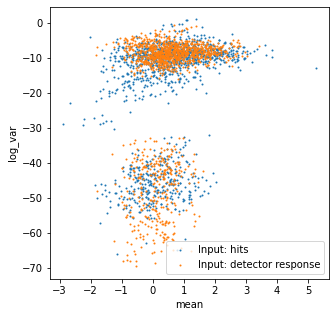

In [77]:
m=mean.to(CPU_DEV).detach().numpy()
v= np.exp(0.5*log_var.to(CPU_DEV).detach().numpy())
m2=mean2.to(CPU_DEV).detach().numpy()
v2= np.exp(0.5*log_var2.to(CPU_DEV).detach().numpy())
#print(m[0])
#print(m[1])
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(m2,2.*np.log(v2),s=1,label='Input: hits')
ax.scatter(m,2.*np.log(v),s=1,label='Input: detector response')
ax.set_xlabel('mean')
ax.set_ylabel('log_var')
ax.legend()
plt.show()

<center>Hidden state parameters for hits (blue) and detector response (orange) encoders</center>

In [78]:
# Encoder 1 TEST reconstruction from DETECTOR RESPONSE
with torch.no_grad():
    t = trainLoader(batch_size)
    x = t[0]
    x = x.view(batch_size, x_dim)
    x = x.to(DEVICE)
    z, mean, log_var = encoder(x)
    x_hat            = decoder(z)

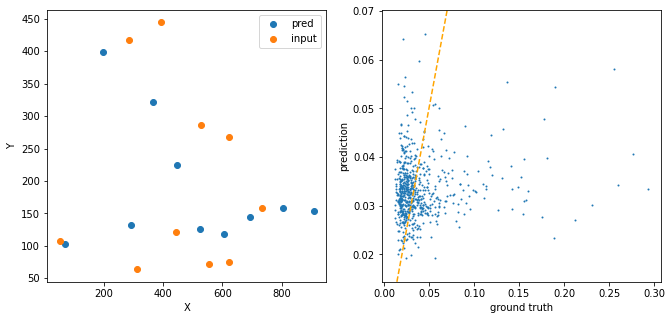

Average deviation is  110.68 pixels


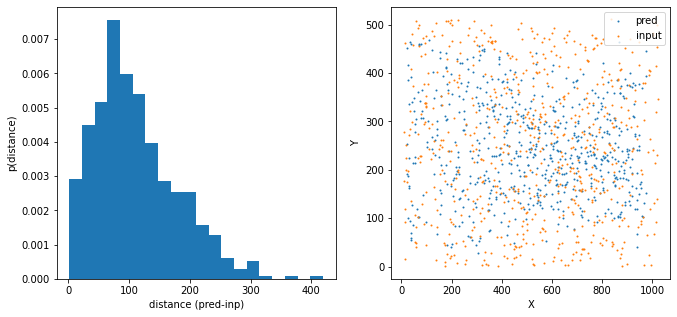

In [79]:
fig, ax = plt.subplots(1,2,figsize=(11,5))

pred = x_hat.to(CPU_DEV)
pred0 = pred[0]
ax[0].scatter([XMAX*pred0[3*i] for i in range(10)],[YMAX*pred0[3*i+1] for i in range(10)],label='pred')
gt = t[1][0]
ax[0].scatter([XMAX*gt[3*i] for i in range(10)],[YMAX*gt[3*i+1] for i in range(10)],label='input')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].legend()

ax[1].scatter(t[1][:,2::3].view(-1,t[1].size()[0]*t[1].size()[1]//3)[0],pred[:,2::3].view(-1,x_hat.size()[0]*x_hat.size()[1]//3)[0], s=1)
ax[1].set_xlabel('ground truth')
ax[1].set_ylabel('prediction')
xl = plt.gca().get_xbound()
yl = plt.gca().get_ybound()
ax[1].axline((max(xl[0],yl[0]),max(xl[0],yl[0])),(min(xl[1],yl[1]),min(xl[1],yl[1])), ls='dashed', color='orange')

plt.show()

Xinp = XMAX*t[1][:,0::3].view(-1,t[1].size()[0]*t[1].size()[1]//3)[0]
Yinp = YMAX*t[1][:,1::3].view(-1,t[1].size()[0]*t[1].size()[1]//3)[0]
Xpred = XMAX*pred[:,0::3].view(-1,pred.size()[0]*pred.size()[1]//3)[0]
Ypred = YMAX*pred[:,1::3].view(-1,pred.size()[0]*pred.size()[1]//3)[0]
dist = torch.sqrt((Xinp-Xpred)**2+(Yinp-Ypred)**2).tolist()
print('Average deviation is {0:7.2f} pixels'.format(np.mean(dist)))

fig, ax = plt.subplots(1,2,figsize=(11,5))

ax[0].hist(dist,density=True,bins=20)
ax[0].set_xlabel('distance (pred-inp)')
ax[0].set_ylabel('p(distance)')

ax[1].scatter(Xpred,Ypred,label='pred',s=1)
ax[1].scatter(Xinp,Yinp,label='input',s=1)
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].legend()

plt.show()

<center>Result for detector response as input</center>

In [80]:
# Encoder 2  TEST reconstruction from HITS
with torch.no_grad():
    t = trainLoader(batch_size)
    x = t[1]
    x = x.view(batch_size, output_dim)
    x = x.to(DEVICE)
    z, mean, log_var = encoder2(x)
    x_hat            = decoder(z)


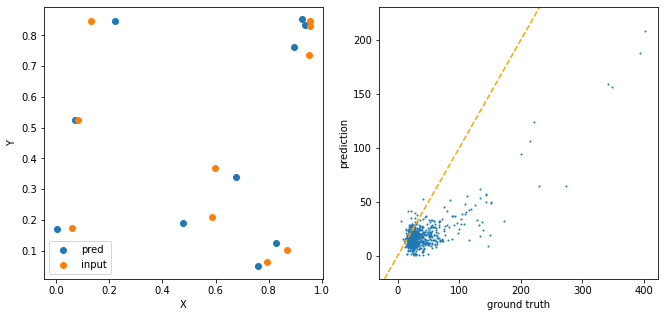

Average deviation is   25.72 pixels


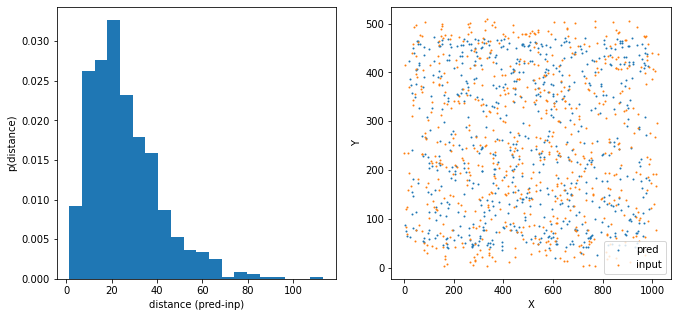

In [81]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(11,5))

pred = x_hat.to(CPU_DEV)
pred0 = pred[0]
ax[0].scatter([pred0[3*i] for i in range(10)],[pred0[3*i+1] for i in range(10)],label='pred')
gt = t[1][0]
ax[0].scatter([gt[3*i] for i in range(10)],[gt[3*i+1] for i in range(10)],label='input')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].legend()

ax[1].scatter(XMAX*t[1][:,2::3].view(-1,t[1].size()[0]*t[1].size()[1]//3)[0],YMAX*pred[:,2::3].view(-1,x_hat.size()[0]*x_hat.size()[1]//3)[0], s=1)
ax[1].set_xlabel('ground truth')
ax[1].set_ylabel('prediction')
xl = plt.gca().get_xbound()
yl = plt.gca().get_ybound()
ax[1].axline((max(xl[0],yl[0]),max(xl[0],yl[0])),(min(xl[1],yl[1]),min(xl[1],yl[1])), ls='dashed', color='orange')

plt.show()

Xinp = XMAX*t[1][:,0::3].view(-1,t[1].size()[0]*t[1].size()[1]//3)[0]
Yinp = YMAX*t[1][:,1::3].view(-1,t[1].size()[0]*t[1].size()[1]//3)[0]
Xpred = XMAX*pred[:,0::3].view(-1,pred.size()[0]*pred.size()[1]//3)[0]
Ypred = YMAX*pred[:,1::3].view(-1,pred.size()[0]*pred.size()[1]//3)[0]
dist = torch.sqrt((Xinp-Xpred)**2+(Yinp-Ypred)**2).tolist()
print('Average deviation is {0:7.2f} pixels'.format(np.mean(dist)))

fig, ax = plt.subplots(1,2,figsize=(11,5))

ax[0].hist(dist,density=True,bins=20)
ax[0].set_xlabel('distance (pred-inp)')
ax[0].set_ylabel('p(distance)')

ax[1].scatter(Xpred,Ypred,label='pred',s=1)
ax[1].scatter(Xinp,Yinp,label='input',s=1)
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].legend()

plt.show()

<center>Result for hits as input</center>

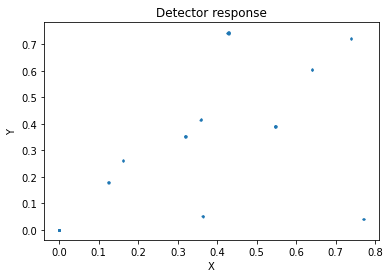

In [30]:
gt = t[0][0]
plt.scatter([gt[2*i] for i in range(len(gt)//2)],[gt[2*i+1] for i in range(len(gt)//2)],s=1)
plt.title('Detector response')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Encoder2 - Decoder model
reconstruction of the input (hits)

In [90]:
encoder2 = Encoder(input_dim=output_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = output_dim)
model3= Model(Encoder=encoder2, Decoder=decoder).to(DEVICE)
optimizer = Adam(model3.parameters(), lr=lr)

# Encoder2 -> Decoder model
print("Start training VAE...")
start = time.time()
model3.train()

loss3 = nn.MSELoss(reduction='sum')
error3 = np.zeros(epochs)

for epoch in range(20):
#for epoch in range(epochs):
    overall_loss = 0
    for batch_idx in range(len(l)//batch_size):
        t = trainLoader(batch_size)
        x = t[1]
#        x = torch.index_select(t[1],1,torch.LongTensor(np.array([[3*i+1,3*i,3*i+2] for i in range(10)]).flatten()))[0]
        x = x.view(batch_size, output_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean2, log_var2 = model3(x)
        
        x_hat = torch.clamp(x_hat,0,1)  # !!! Cross-entropy safekeeping
        
#        loss = loss_function(t[1], x_hat, mean2, log_var2)  
        loss = loss3(x, x_hat)  
#        loss = loss3(t[1], x_hat)  
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    error3[epoch] = overall_loss / (batch_idx*batch_size)
    
    
print("Finished!! in {} seconds".format(time.time()-start))

Start training VAE...
	Epoch 1 complete 	Average Loss:  0.3510098339093102
	Epoch 2 complete 	Average Loss:  0.06274136114003169
	Epoch 3 complete 	Average Loss:  0.04943288395866757
	Epoch 4 complete 	Average Loss:  0.04568654726874574
	Epoch 5 complete 	Average Loss:  0.04445827472181409
	Epoch 6 complete 	Average Loss:  0.03974875268543528
	Epoch 7 complete 	Average Loss:  0.0359988477317843
	Epoch 8 complete 	Average Loss:  0.03309674418685065
	Epoch 9 complete 	Average Loss:  0.03183772311532119
	Epoch 10 complete 	Average Loss:  0.030838115083618084
	Epoch 11 complete 	Average Loss:  0.029811437841425436
	Epoch 12 complete 	Average Loss:  0.028880874917944357
	Epoch 13 complete 	Average Loss:  0.028039765041408964
	Epoch 14 complete 	Average Loss:  0.02647999542102395
	Epoch 15 complete 	Average Loss:  0.02520935805282381
	Epoch 16 complete 	Average Loss:  0.02450216862511962
	Epoch 17 complete 	Average Loss:  0.023922367559583792
	Epoch 18 complete 	Average Loss:  0.023401451133

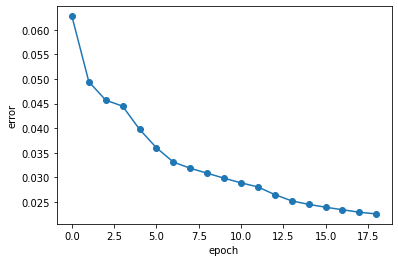

In [94]:
plt.plot(range(len(error3[1:20])),error3[1:20])
plt.scatter(range(len(error3[1:20])),error3[1:20])
#plt.yscale('log')
plt.xlabel('epoch')
#plt.ylim(0.018,0.065)
#plt.xscale('log')
plt.ylabel('error')
plt.show()

In [95]:
# How to save configuration
state = {'epoch': epoch + 1, 'state_dict': model3.state_dict(),
             'optimizer': optimizer.state_dict(), 'errors': error3}
torch.save(state, 'model3_20epoch.pth')

#torch.save(model3.state_dict(),'model3_40epoch.pth')
#model3 = Model3(*args, **kwargs)  ? model3= Model(Encoder=encoder2, Decoder=decoder).to(DEVICE)
#model3.load_state_dict(torch.load('model3_40epoch.pth'))
#model3.eval()

In [ ]:
# How to load configuration
def load_checkpoint(model, optimizer, errors, filename='checkpoint.pth.tar'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
#        losslogger = checkpoint['losslogger']
        errors = checkpoint['errors']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, errors

model3, optimizer, start_epoch, error3 = load_checkpoint(model3, optimizer, error3)
model3 = model3.to(device)
# now individually transfer the optimizer parts...
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

In [96]:
with torch.no_grad():
    t = trainLoader(batch_size)
    x = t[1]
#    x = torch.index_select(t[1],1,torch.LongTensor(np.array([[3*i+1,3*i,3*i+2] for i in range(10)]).flatten()))[0]
    x = x.view(batch_size, output_dim)
    x = x.to(DEVICE)
    z, mean, log_var = encoder2(x)
    x_hat            = decoder(z)

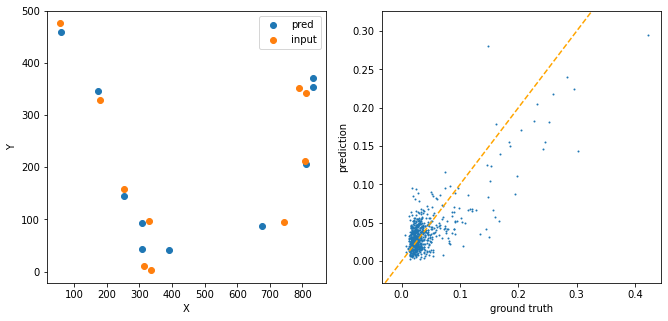

Average deviation is   26.73 pixels


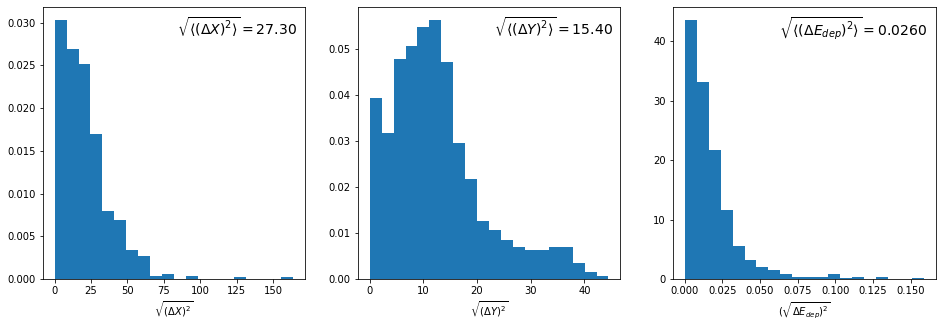

In [114]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(11,5))

pred = x_hat.to(CPU_DEV)
ax[0].scatter([XMAX*pred[0][3*i] for i in range(10)],[YMAX*pred[0][3*i+1] for i in range(10)],label='pred')

ax[0].scatter([XMAX*t[1][0][3*i] for i in range(10)],[YMAX*t[1][0][3*i+1] for i in range(10)],label='input')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].legend()

#ax[1].scatter(t[1][:,2::3].view(-1,x.size()[0]*x.size()[1]//3)[0],x_hat[:,2::3].view(-1,x_hat.size()[0]*x_hat.size()[1]//3)[0], s=1)
ax[1].scatter(t[1][:,2::3],pred[:,2::3], s=1)
ax[1].set_xlabel('ground truth')
ax[1].set_ylabel('prediction')
xl = plt.gca().get_xbound()
yl = plt.gca().get_ybound()
ax[1].axline((max(xl[0],yl[0]),max(xl[0],yl[0])),(min(xl[1],yl[1]),min(xl[1],yl[1])), ls='dashed', color='orange')

plt.show()

Xinp = XMAX*t[1][:,0::3].view(-1,t[1].size()[0]*t[1].size()[1]//3)[0]
Yinp = YMAX*t[1][:,1::3].view(-1,t[1].size()[0]*t[1].size()[1]//3)[0]
Xpred = XMAX*pred[:,0::3].view(-1,pred.size()[0]*pred.size()[1]//3)[0]
Ypred = YMAX*pred[:,1::3].view(-1,pred.size()[0]*pred.size()[1]//3)[0]
dist = torch.sqrt((Xinp-Xpred)**2+(Yinp-Ypred)**2).tolist()
print('Average deviation is {0:7.2f} pixels'.format(np.mean(dist)))

fig, ax = plt.subplots(1,3,figsize=(16,5))

tt = np.array([XMAX*(t[1][j][0::3].numpy()-pred[j][0::3].numpy()) for j in range(batch_size)])
ax[0].hist(np.sqrt(tt.flatten()**2), density=True,bins=20)
ax[0].set_xlabel(r'$\sqrt{{(\Delta X)^2}}$')
ax[0].text(0.97,0.97,r'$\sqrt{{\langle(\Delta X)^2\rangle}}=${0:.2f}'.format(np.sqrt(np.mean(tt.flatten()**2))),horizontalalignment='right',verticalalignment='top',transform=ax[0].transAxes,fontsize=14)

tt = np.array([YMAX*(t[1][j][1::3].numpy()-pred[j][1::3].numpy()) for j in range(64)])
ax[1].hist(np.sqrt(tt.flatten()**2), density=True,bins=20)
ax[1].set_xlabel(r'$\sqrt{{(\Delta Y)^2}}$')
ax[1].text(0.97,0.97,r'$\sqrt{{\langle(\Delta Y)^2\rangle}}=${0:.2f}'.format(np.sqrt(np.mean(tt.flatten()**2))),horizontalalignment='right',verticalalignment='top',transform=ax[1].transAxes,fontsize=14)

tt = np.array([t[1][j][2::3].numpy()-pred[j][2::3].numpy() for j in range(64)])
ax[2].hist(np.sqrt(tt.flatten()**2), density=True,bins=20)
ax[2].set_xlabel(r'$(\sqrt{{\Delta E_{dep})^2}}$')
ax[2].text(0.97,0.97,r'$\sqrt{{\langle(\Delta E_{{dep}})^2\rangle}}=${0:.4f}'.format(np.sqrt(np.mean(tt.flatten()**2))),horizontalalignment='right',verticalalignment='top',transform=ax[2].transAxes,fontsize=14)

plt.show()

In [ ]:
# Encoder / Decoder on Y only data
encoder_single = Encoder(input_dim=10, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder_single = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = 10)
model_single = Model(Encoder=encoder_single, Decoder=decoder_single).to(DEVICE)
optimizer = Adam(model_single.parameters(), lr=lr)

print("Start training VAE...")
model_single.train()

loss3 = nn.MSELoss(reduction='sum')

#for epoch in range(epochs):
for epoch in range(10):
    overall_loss = 0
#    for batch_idx in range(len(l)//batch_size):
    for batch_idx in range(1000):
        t = trainLoader(batch_size)
        x = torch.index_select(t[1],1,torch.LongTensor([3*i+2 for i in range(10)]))
        x = x.view(batch_size, 10)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model_single(x)
        
        x_hat = torch.clamp(x_hat,0,1)  # !!! Cross-entropy safekeeping
        
        loss = loss3(x, x_hat)  
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
    
print("Finish!!")

with torch.no_grad():
    t = trainLoader(batch_size)
    x = torch.index_select(t[1],1,torch.LongTensor([3*i+2 for i in range(10)]))
    x = x.view(batch_size, 10)
    x = x.to(DEVICE)
    z, mean, log_var = encoder_single(x)
    x_hat            = decoder_single(z)

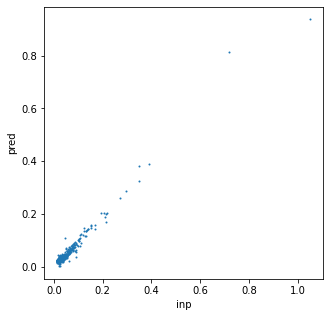

In [144]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(x,x_hat,s=1)
ax.set_xlabel('inp')
ax.set_ylabel('pred')

plt.show()